In [2]:
# 1. Importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 2. Load the customer_value_analysis.csv into the variable customer_df
customer_df = pd.read_csv("customer_value_analysis.csv")

# 3. Examine its main features
head = customer_df.head()
shape = customer_df.shape
info = customer_df.info()

head, shape


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9134 entries, 0 to 9133
Data columns (total 24 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Customer                       9134 non-null   object 
 1   State                          9134 non-null   object 
 2   Customer Lifetime Value        9134 non-null   float64
 3   Response                       9134 non-null   object 
 4   Coverage                       9134 non-null   object 
 5   Education                      9134 non-null   object 
 6   Effective To Date              9134 non-null   object 
 7   EmploymentStatus               9134 non-null   object 
 8   Gender                         9134 non-null   object 
 9   Income                         9134 non-null   int64  
 10  Location Code                  9134 non-null   object 
 11  Marital Status                 9134 non-null   object 
 12  Monthly Premium Auto           9134 non-null   i

(  Customer       State  Customer Lifetime Value Response  Coverage Education  \
 0  BU79786  Washington              2763.519279       No     Basic  Bachelor   
 1  QZ44356     Arizona              6979.535903       No  Extended  Bachelor   
 2  AI49188      Nevada             12887.431650       No   Premium  Bachelor   
 3  WW63253  California              7645.861827       No     Basic  Bachelor   
 4  HB64268  Washington              2813.692575       No     Basic  Bachelor   
 
   Effective To Date EmploymentStatus Gender  Income  ...  \
 0           2/24/11         Employed      F   56274  ...   
 1           1/31/11       Unemployed      F       0  ...   
 2           2/19/11         Employed      F   48767  ...   
 3           1/20/11       Unemployed      M       0  ...   
 4            2/3/11         Employed      M   43836  ...   
 
   Months Since Policy Inception Number of Open Complaints  Number of Policies  \
 0                             5                         0    

In [3]:
# 1. Rename the columns to follow the PE8 (snake case: lowercase_with_underscores)
customer_df.columns = [col.lower().replace(" ", "_") for col in customer_df.columns]

# 2. Change the type of `effective_to_date` column to DateTime format
customer_df['effective_to_date'] = pd.to_datetime(customer_df['effective_to_date'])

# 3. Check for NaN values per column
nan_values = customer_df.isna().sum()

nan_values


customer                         0
state                            0
customer_lifetime_value          0
response                         0
coverage                         0
education                        0
effective_to_date                0
employmentstatus                 0
gender                           0
income                           0
location_code                    0
marital_status                   0
monthly_premium_auto             0
months_since_last_claim          0
months_since_policy_inception    0
number_of_open_complaints        0
number_of_policies               0
policy_type                      0
policy                           0
renew_offer_type                 0
sales_channel                    0
total_claim_amount               0
vehicle_class                    0
vehicle_size                     0
dtype: int64

In [4]:
# 1. Define a function to segregate numerical and categorical columns
def segregate_columns(df):
    """
    Returns two dataframes: one with numerical columns and another with categorical columns.
    """
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    df_numeric = df.select_dtypes(include=numerics)
    df_categorical = df.select_dtypes(exclude=numerics)
    return df_numeric, df_categorical

numeric_df, categorical_df = segregate_columns(customer_df)

# 2. Drop any ID column (assuming 'customer' is an ID column)
customer_df.drop(columns=['customer'], inplace=True)

# 3. Get the correlation matrix for the numerical variables
correlation_matrix = numeric_df.corr()
highest_corr_pair = correlation_matrix.unstack().sort_values(ascending=False).drop_duplicates().index[1]

correlation_matrix, highest_corr_pair


(                               customer_lifetime_value    income  \
 customer_lifetime_value                       1.000000  0.024366   
 income                                        0.024366  1.000000   
 monthly_premium_auto                          0.396262 -0.016665   
 months_since_last_claim                       0.011517 -0.026715   
 months_since_policy_inception                 0.009418 -0.000875   
 number_of_open_complaints                    -0.036343  0.006408   
 number_of_policies                            0.021955 -0.008656   
 total_claim_amount                            0.226451 -0.355254   
 
                                monthly_premium_auto  months_since_last_claim  \
 customer_lifetime_value                    0.396262                 0.011517   
 income                                    -0.016665                -0.026715   
 monthly_premium_auto                       1.000000                 0.005026   
 months_since_last_claim                    0.005026 

In [6]:
def segregate_continuous_discrete(df, threshold=36):
    """
    Returns two dataframes: one with numerical continuous columns and another with numerical discrete columns.
    """
    discrete_cols = [col for col in df.columns if df[col].nunique() < threshold]
    continuous_cols = list(set(df.columns) - set(discrete_cols))
    
    return df[continuous_cols], df[discrete_cols]

continuous_df, discrete_df = segregate_continuous_discrete(numeric_df)

continuous_df.head(), discrete_df.head()


(   total_claim_amount  months_since_last_claim  monthly_premium_auto  \
 0          384.811147                       32                    69   
 1         1131.464935                       13                    94   
 2          566.472247                       18                   108   
 3          529.881344                       18                   106   
 4          138.130879                       12                    73   
 
    months_since_policy_inception  customer_lifetime_value  income  
 0                              5              2763.519279   56274  
 1                             42              6979.535903       0  
 2                             38             12887.431650   48767  
 3                             65              7645.861827       0  
 4                             44              2813.692575   43836  ,
    number_of_open_complaints  number_of_policies
 0                          0                   1
 1                          0                

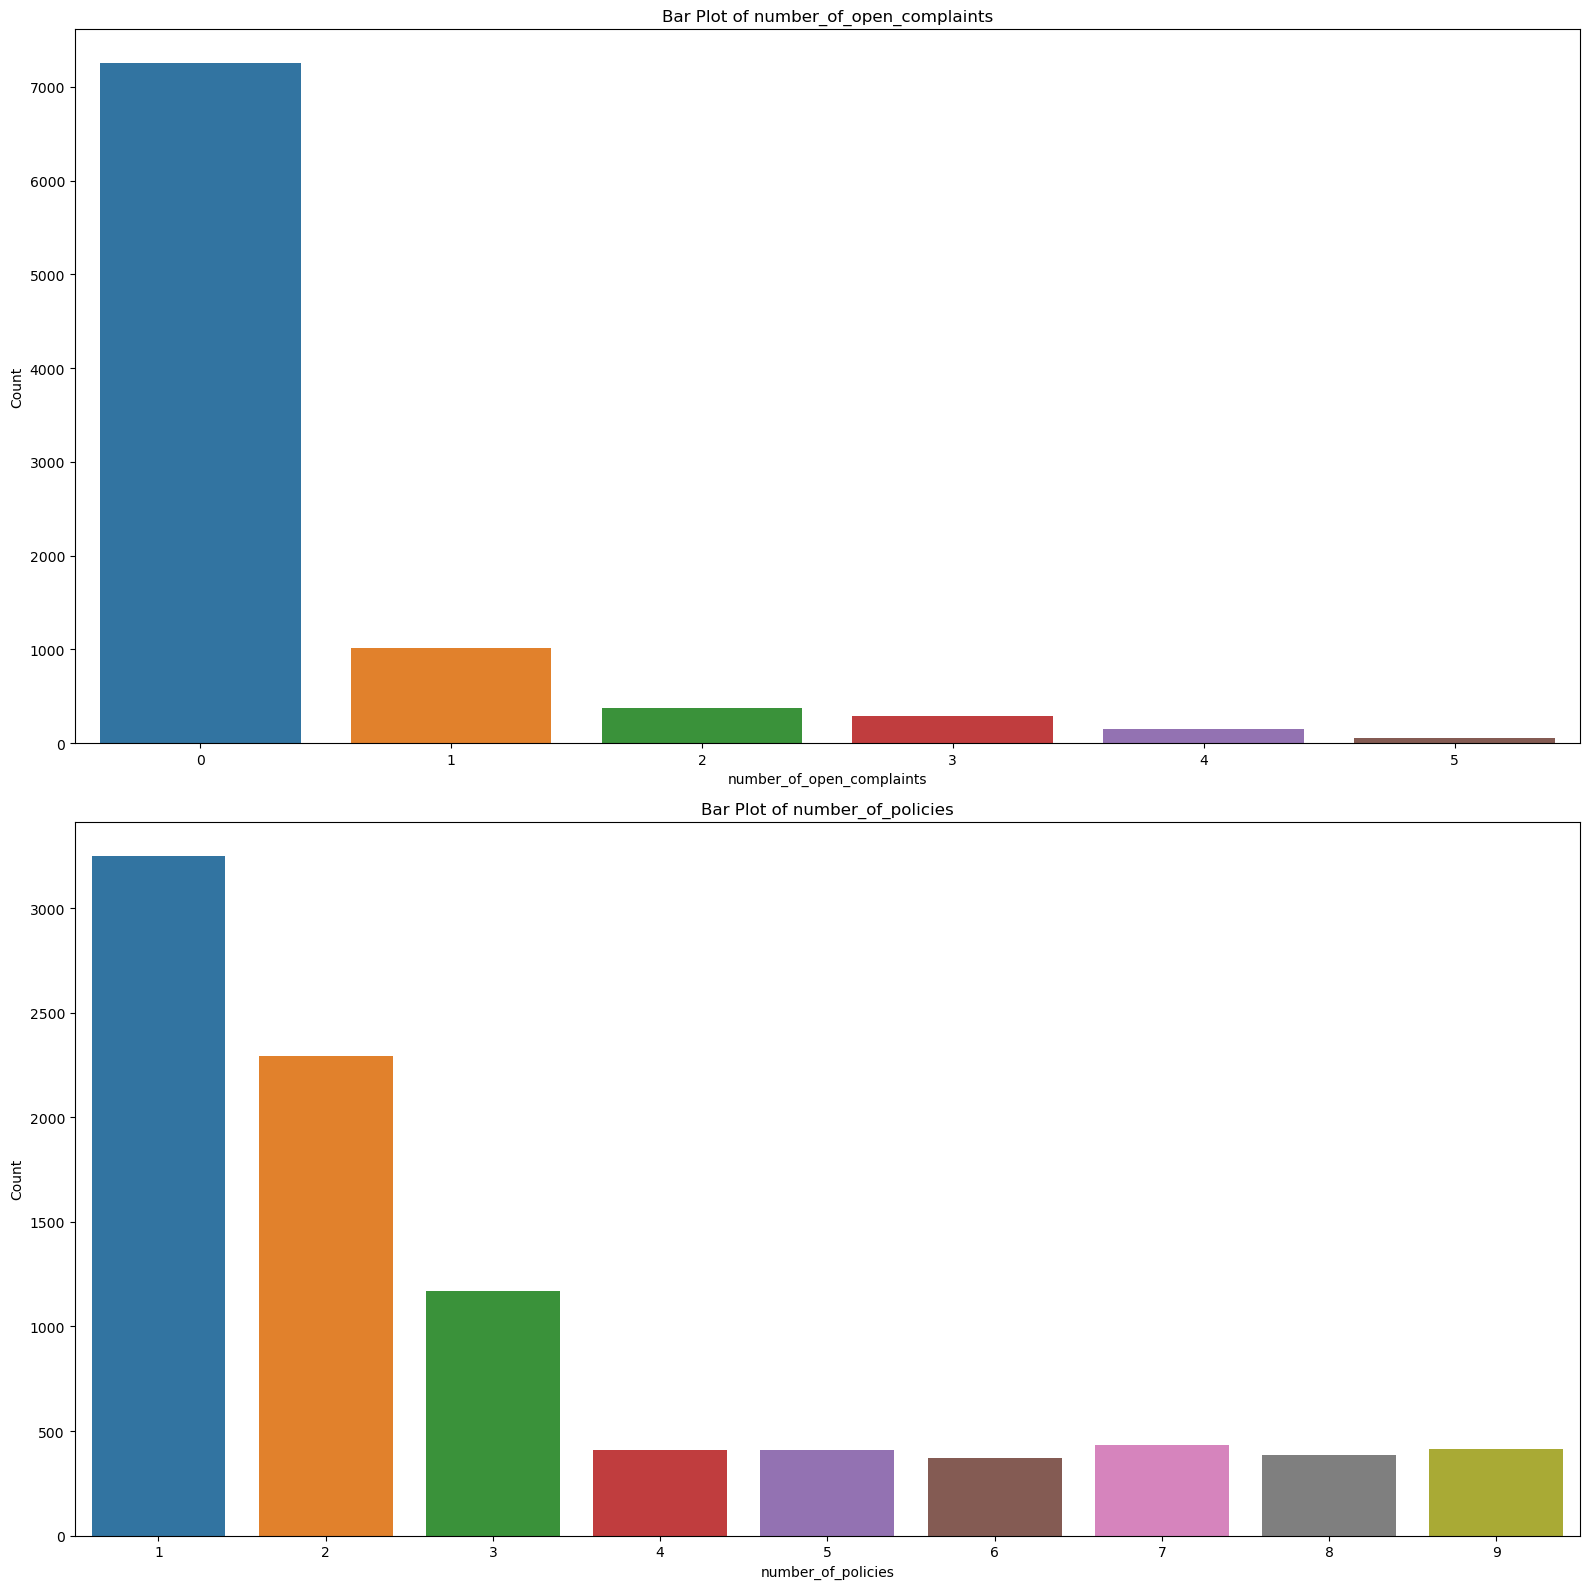

In [7]:
def plot_bar_discrete(df):
    """
    Generates bar plots for all columns in a DataFrame using seaborn.
    """
    n = len(df.columns)
    plt.figure(figsize=(16, 16))
    
    for i, col in enumerate(df.columns, 1):
        plt.subplot(n, 1, i)
        sns.countplot(data=df, x=col)
        plt.title(f'Bar Plot of {col}')
        plt.ylabel('Count')
        plt.tight_layout()

def plot_histogram_continuous(df):
    """
    Generates histograms for all columns in a DataFrame using seaborn.
    """
    n = len(df.columns)
    plt.figure(figsize=(16, 16))
    
    for i, col in enumerate(df.columns, 1):
        plt.subplot(n, 1, i)
        sns.histplot(df[col], kde=True, bins=30)
        plt.title(f'Histogram of {col}')
        plt.xlabel(col)
        plt.ylabel('Density')
        plt.tight_layout()

# Plotting bar plots for discrete_df
plot_bar_discrete(discrete_df)


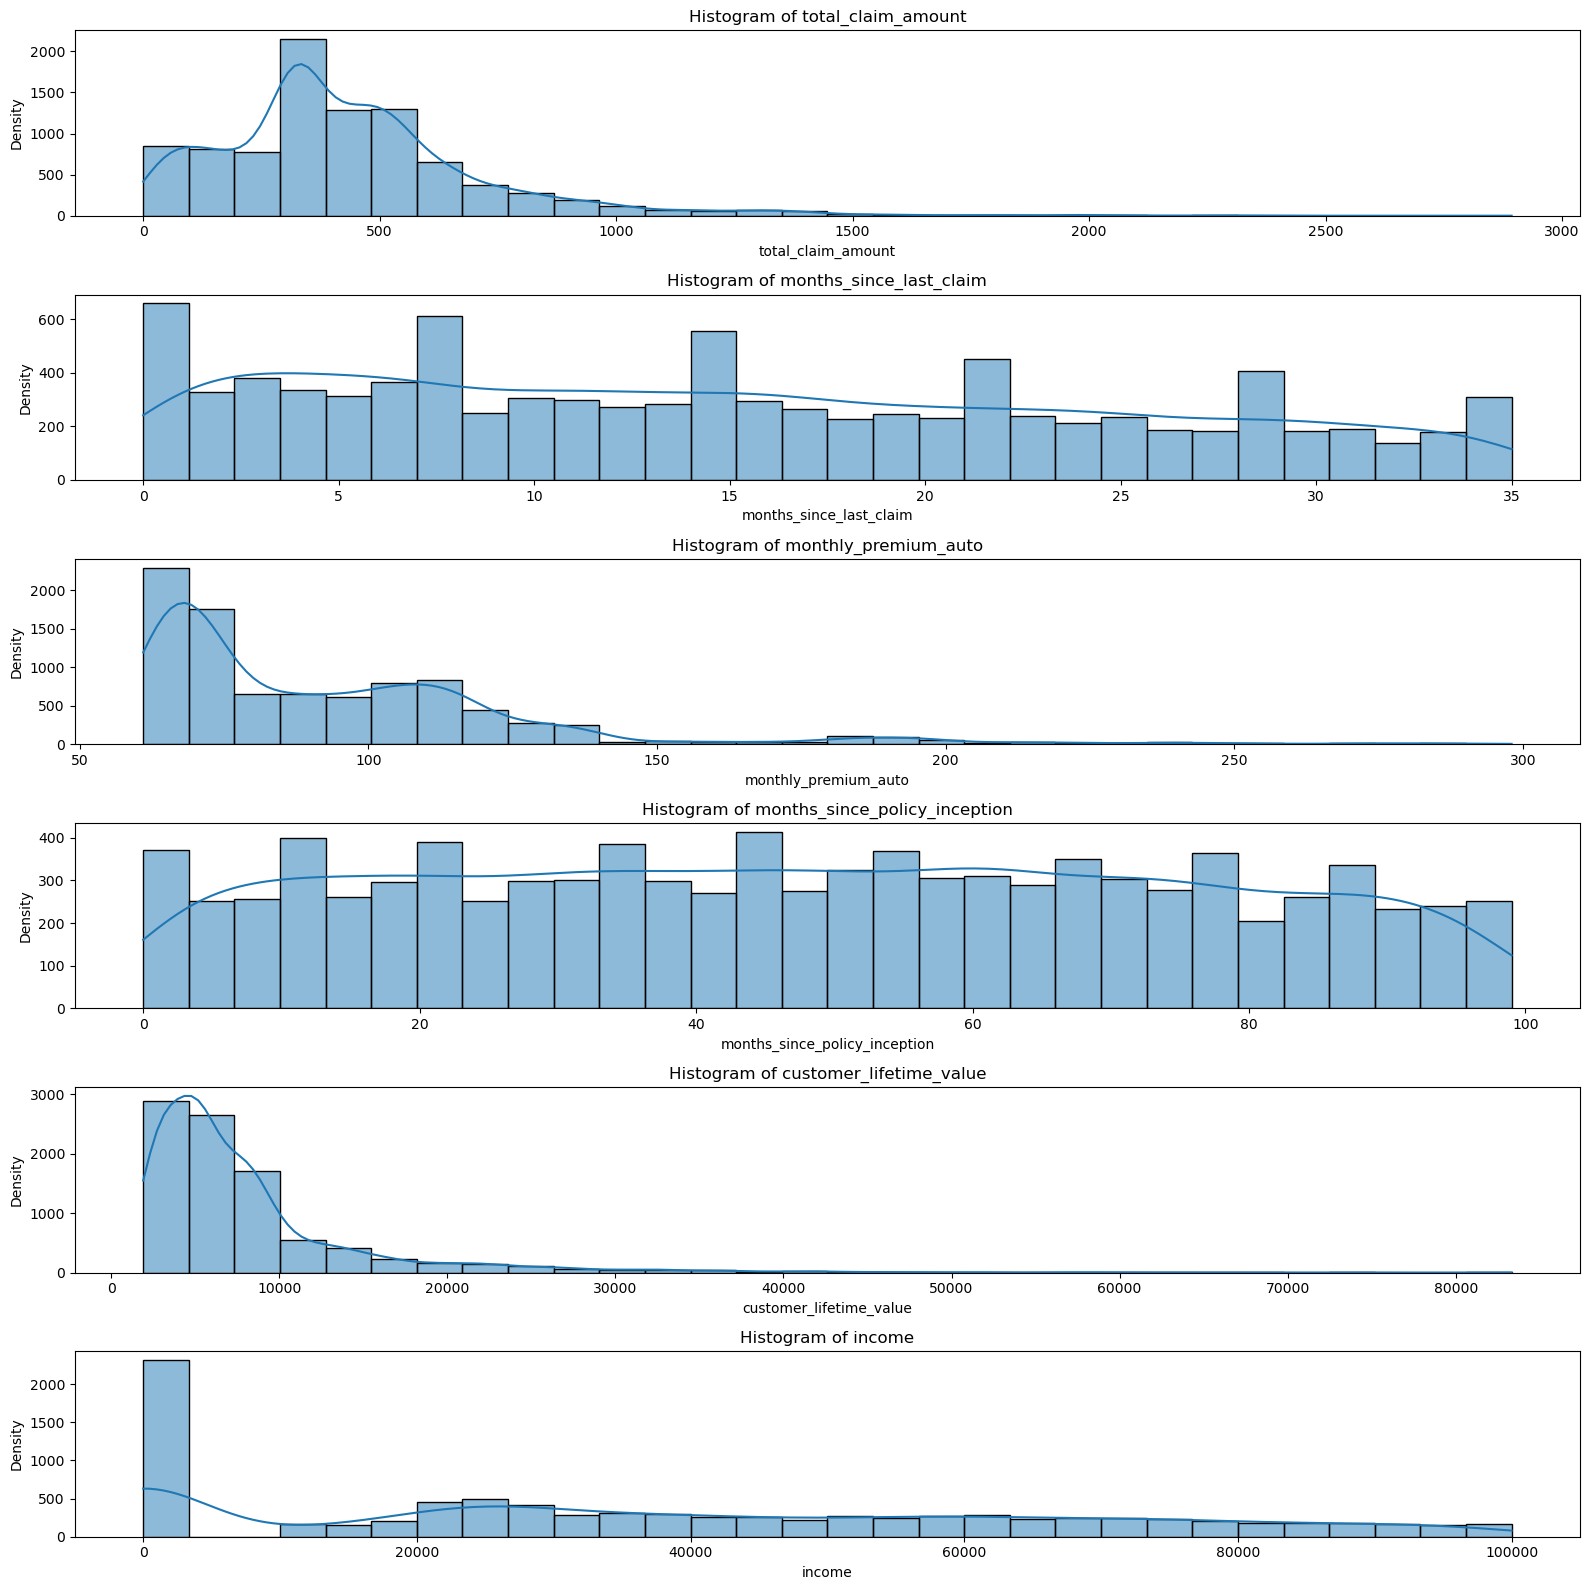

In [8]:
# Plotting histograms for continuous_df
plot_histogram_continuous(continuous_df)


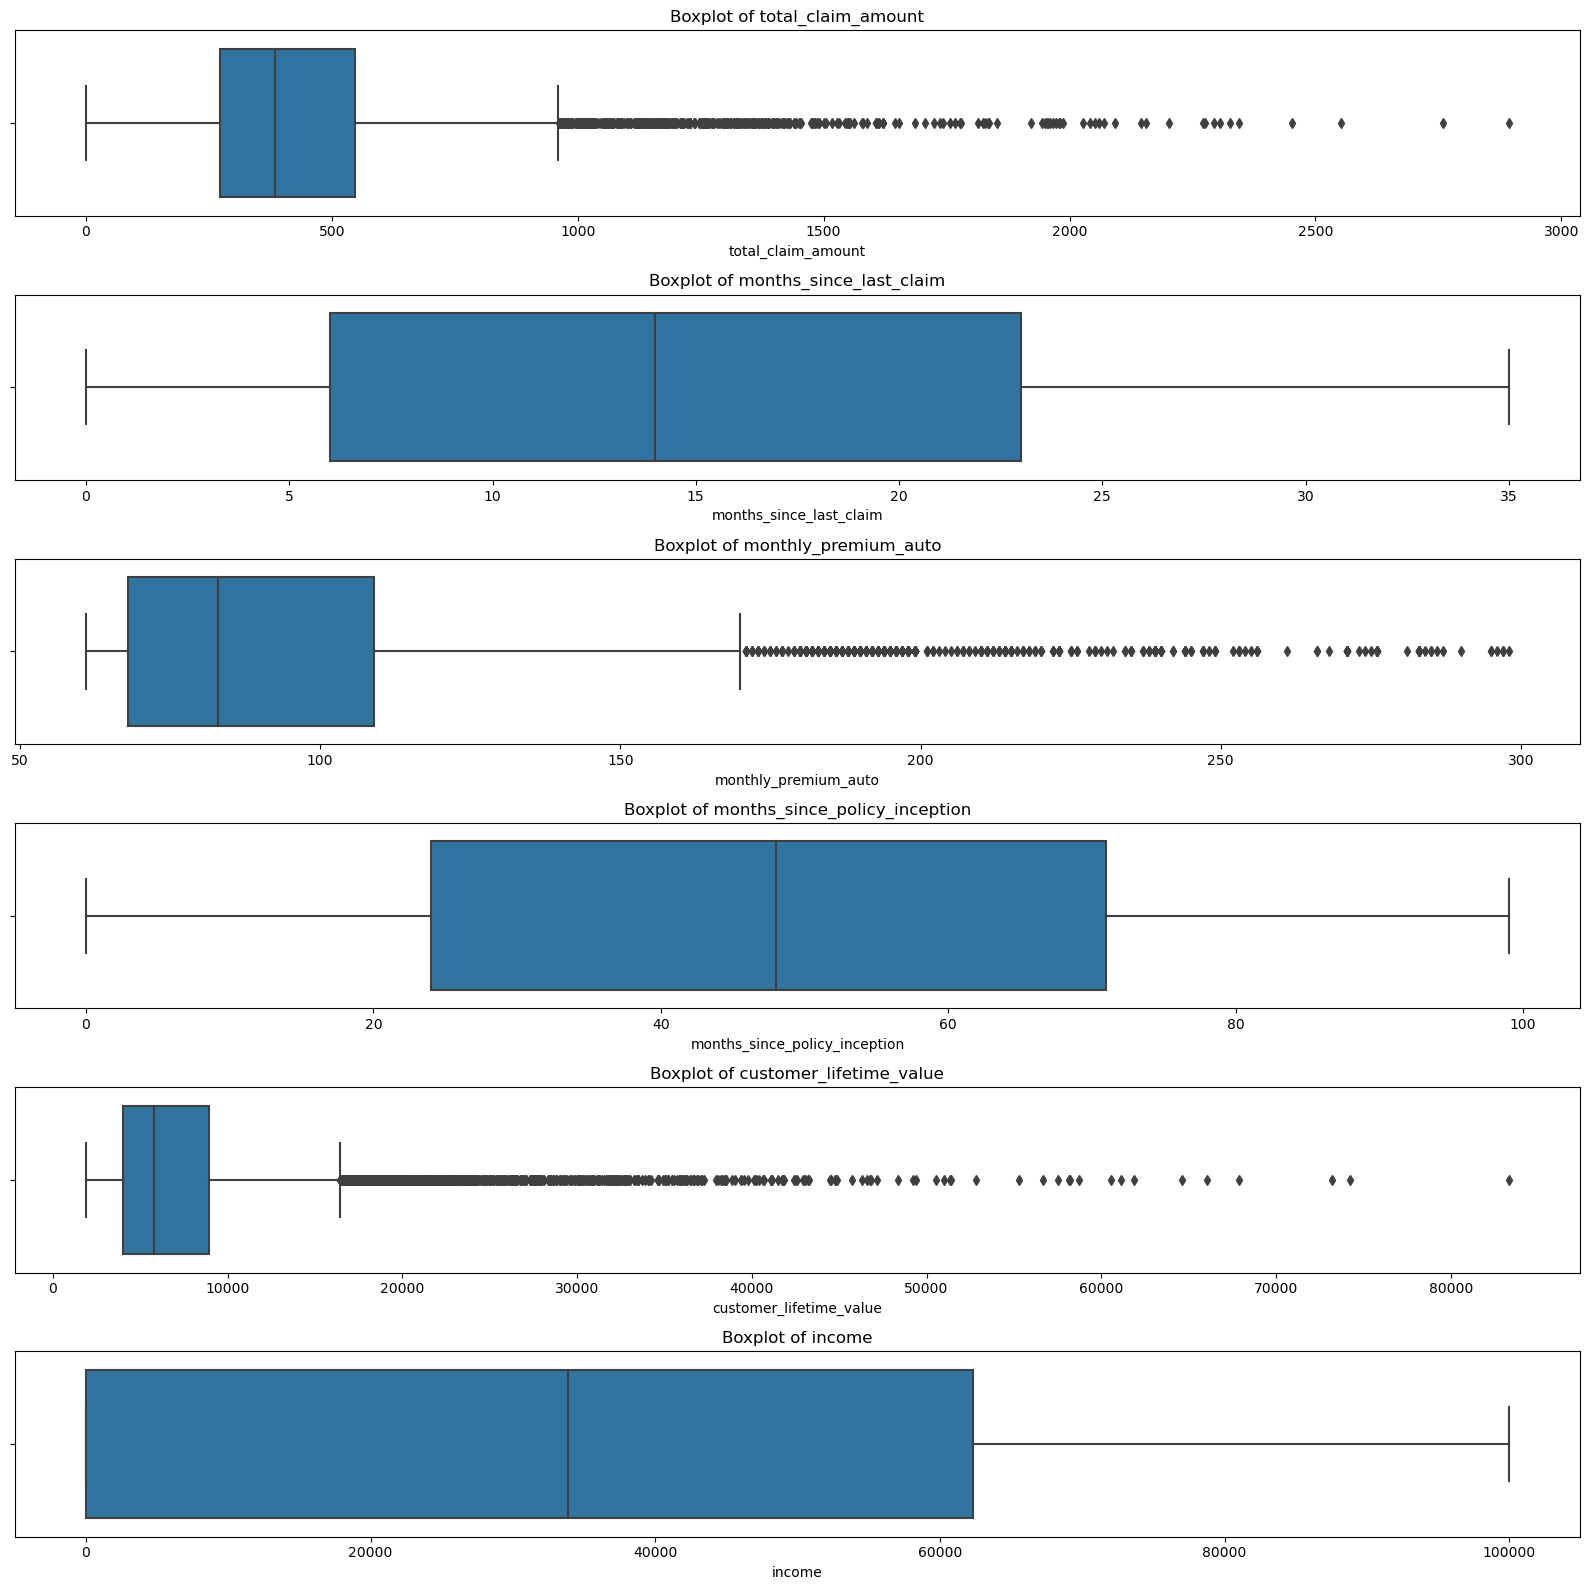

In [9]:
def plot_boxplots_continuous(df):
    """
    Generates boxplots for all columns in a DataFrame to visualize outliers.
    """
    n = len(df.columns)
    plt.figure(figsize=(16, 16))
    
    for i, col in enumerate(df.columns, 1):
        plt.subplot(n, 1, i)
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot of {col}')
        plt.tight_layout()

# Plotting boxplots for continuous_df
plot_boxplots_continuous(continuous_df)
